In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
!cp "/content/drive/MyDrive/Colab_Notebooks/Data/PennFudanPed.zip" "/content/PennFudanPed.zip" 
!unzip -qq "/content/PennFudanPed.zip"
print(os.listdir('/content/PennFudanPed/'))

['readme.txt', 'added-object-list.txt', 'PNGImages', 'Annotation', 'PedMasks']


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks
!git clone https://github.com/yoojy31/pytorch-object-detection-tutorial.git

/content/drive/MyDrive/Colab_Notebooks
fatal: destination path 'pytorch-object-detection-tutorial' already exists and is not an empty directory.


In [ ]:
# 너무 복잡한 부분은 외부에서 불러오고, colab 에서는 생략
%cd 'pytorch-object-detection-tutorial'
import engine, utils, coco_eval, coco_utils
import transforms as T
%cd /content

/content/drive/MyDrive/Colab_Notebooks/pytorch-object-detection-tutorial
/content


In [ ]:
# 필요한 라이브러리

import os
import sys
import math

import numpy as np
import torch
import torch.nn as nn
from PIL import Image

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor

In [ ]:
def main():
    # gpu 가 불가능하면 cpu 로 학습
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Data Loader
    data_loader, data_loader_test = create_dataset_and_dataloader(root='PennFudanPed')

    # Model
    model = create_faster_rcnn()
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # let's train it for 5 epochs
    num_epochs = 5
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [ ]:
def create_dataset_and_dataloader(root='PennFudanPed'):
  dataset = PennFudanDataset(root, get_transform(train=True))
  dataset_test = PennFudanDataset(root, get_transform(train=False))

  # split the dataset in train and test set
  indices = list(range(len(dataset)))
  dataset = torch.utils.data.Subset(dataset, indices[:-50])
  dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

  # define training and validation data loaders
  data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=2, shuffle=True, num_workers=4,
      collate_fn=utils.collate_fn)

  data_loader_test = torch.utils.data.DataLoader(
      dataset_test, batch_size=1, shuffle=False, num_workers=4,
      collate_fn=utils.collate_fn)
  return data_loader, data_loader_test


In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    '''
    PennFudanPed/
      PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
      PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png
    '''
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # mask --> 0 : 배경, 1 : 보행자 
        mask = np.array(mask) # convert the PIL Image into a numpy array
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:] # index 0 은 배경이라서 제거
        masks = mask == obj_ids[:, None, None]

        # mask 로부터 box를 생성 
        num_objs = len(obj_ids) 
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # torch tensor 로 변환
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
  
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[[ 93.,  52., 232., 345.]]]), 'labels': tensor([[1]]), 'masks': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8), 'image_id': tensor([[32]]), 'area': tensor([[40727.]]), 'iscrowd': tensor([[0]])}


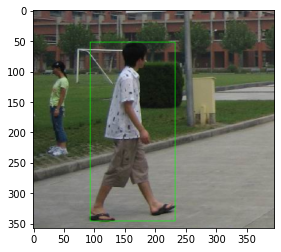

In [ ]:
# 데이터 테스트 출력

import cv2
import matplotlib.pyplot as plt

# 박스 시각화
def makeBox(voc_im, bbox):
  image = voc_im.copy()
  for i in range(len(bbox)):
    cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
  return image


dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True)

for i, (image, targets) in enumerate(dataloader):
  test_image = image
  test_target = targets
  if i == 0 : break

print(test_target)

plot_image = makeBox(test_image.squeeze(0).permute(1,2,0).numpy(),test_target['boxes'].squeeze(0))
plt.imshow(plot_image)

In [ ]:
def create_faster_rcnn():
    resnet = torchvision.models.resnet50(pretrained=True)
    backbone = nn.Sequential(
        resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
        resnet.layer1, resnet.layer2, resnet.layer3,
    )
    # print(backbone(torch.rand(4, 3, 800, 800)).shape)
    backbone.out_channels = 1024

    rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

    num_anchors = 5 * 3
    in_channels = backbone.out_channels
    rpn_head = RPNHead(in_channels, num_anchors)
    # prob, box_delta = rpn_head([torch.rand(4, 1024, 50, 50)])
    # print(box_delta[0].shape, prob[0].shape)

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2)
    # print(roi_pooler(
    #     x={'0': torch.rand(4, 1024, 50, 50)},
    #     boxes=[torch.randint(0, 800, size=(100, 4)).float()] * 4,
    #     image_shapes=[(800, 800)] * 4).shape)

    in_channles = 7 * 7 * backbone.out_channels
    representation_size = 2048
    box_base = TwoMLPHead(in_channels=in_channles,
                          representation_size=representation_size)
    # print(box_base(torch.rand(400, 1024, 7, 7)).shape)

    num_classes = 2
    box_predictor = FastRCNNPredictor(in_channels=representation_size, num_classes=num_classes)
    # prob, box_delta = box_predictor(torch.rand(400, 2048))
    # print(prob.shape, box_delta.shape)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       # num_classes=2,
                       rpn_head=rpn_head,
                       rpn_anchor_generator=rpn_anchor_generator,
                       box_roi_pool=roi_pooler,
                       box_head=box_base,
                       box_predictor=box_predictor)
    return model

In [ ]:
if False:
  resnet = torchvision.models.resnet50(pretrained=True)
  backbone = nn.Sequential(
      resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
      resnet.layer1, resnet.layer2, resnet.layer3,
  )

  input_img = torch.rand(8, 3, 800, 800)
  output_feature = backbone(input_img)
  print('input : image batch {}'.format(input_img.shape))
  print('output : backbone feature {}'.format(output_feature.shape))

In [ ]:
if False:
  rpn_head = RPNHead(in_channels=1024, num_anchors=5*3) # 1024 : backbone의 output channel

  backbone_feature_map = torch.rand(8, 1024, 50, 50)

  prob, box_delta = rpn_head([backbone_feature_map])
  print('intput : backbone feature {}'.format(backbone_feature_map.shape))
  print('output : prob {}  and  box_delta {}'.format(prob[0].shape, box_delta[0].shape))

In [ ]:
if False:
  rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
  images = torch.rand(1, 3, 800, 800)
  features = torch.rand(1, 1024, 50, 50)

  from torchvision.models.detection.image_list import ImageList
  images = ImageList(images, [(800, 800)])

  anchors = rpn_anchor_generator(images, features)

  print('input : images, features  {}, {}'.format(images.tensors.shape, features.shape))
  print('output : anchors  {}'.format(anchors[0].shape)) # 37,500 == 50x50 x 15

  draw_img = torch.zeros(800, 800, 3).numpy()
  # 박스 시각화
  def makeBox(voc_im, bbox):
    image = voc_im.copy()
    for i in range(len(bbox)):
      cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 2)
    return image

  selected_boxes = anchors[0][20000:20015]

  print(selected_boxes)
  plot_image = makeBox(draw_img, selected_boxes)
  plt.imshow(plot_image)


In [ ]:
if False:
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
          featmap_names=['0'], output_size=7, sampling_ratio=2)

  backbone_feature_map = torch.rand(8, 1024, 50, 50)
  box_of_rpn = [torch.randint(0, 800, size=(100, 4)).float()] * 8
  print('[input]')
  print('backbone feature  {}'.format(backbone_feature_map.shape))
  print('box :  batch {}  and  shape : {}'.format(len(box_of_rpn), box_of_rpn[0].shape))
  print()
  print('output : ', roi_pooler(
      x={'0': backbone_feature_map},
      boxes=box_of_rpn,
      image_shapes=[(800, 800)] * 8).shape)

In [ ]:
if False:
  box_base = TwoMLPHead(in_channels=7*7*1024,
                            representation_size=2048)

  roi_pooling_result = torch.rand(800, 1024, 7, 7)
  output = box_base(roi_pooling_result)

  print('input : roi pooling result  {}'.format(roi_pooling_result.shape))
  print('output : box base feature  {}'.format(output.shape))

In [ ]:
if False:
  num_classes = 2
  box_predictor = FastRCNNPredictor(in_channels=2048, num_classes=num_classes)

  box_base_result = torch.rand(800, 2048)
  prob, box_delta = box_predictor(box_base_result)

  print('input : roi pooling result  {}'.format(box_base_result.shape))
  print('output : box prob  {}   and    box delta {}'.format(prob.shape, box_delta.shape))

In [ ]:
def create_pretrained_faster_rcnn():
    # COCO 에서 학습된 weight 를 불러오기
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # COCO는 80 클래스. 클래스 개수가 달라졌기에 클래스 분류 layer 를 교체해줘야 함.
    num_classes = 2  # 1 class (person) + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def create_pretrained_ssd():
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
    # feature_maps = model.backbone(torch.rand(4, 3, 320, 320))
    # print(len(feature_maps), feature_maps.keys())
    # print(feature_maps['0'].shape, feature_maps['1'].shape, feature_maps['2'].shape,
    #       feature_maps['3'].shape, feature_maps['4'].shape, feature_maps['5'].shape)
    # out = model.head(list(feature_maps.values()))
    # print(out['bbox_regression'].shape, out['cls_logits'].shape)
    return model

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()

    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    # for images, targets in data_loader:
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        # []
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value): # loss 가 무한대 되면 강제 정지
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        # loss 계산 후 backward  &  파라미터 update
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # 학습 과정 log
        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [ ]:

import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for image, targets in metric_logger.log_every(data_loader, 100, header):
        image = list(img.to(device) for img in image)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(image)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator


In [ ]:
if __name__ == "__main__":
    main()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/60]  eta: 0:02:03  lr: 0.005000  loss: 1.6811 (1.6811)  loss_classifier: 0.7002 (0.7002)  loss_box_reg: 0.0860 (0.0860)  loss_objectness: 0.6942 (0.6942)  loss_rpn_box_reg: 0.2008 (0.2008)  time: 2.0524  data: 0.2770  max mem: 4155
Epoch: [0]  [10/60]  eta: 0:01:16  lr: 0.005000  loss: 1.4390 (1.4576)  loss_classifier: 0.6115 (0.5982)  loss_box_reg: 0.0803 (0.0779)  loss_objectness: 0.6890 (0.6886)  loss_rpn_box_reg: 0.0949 (0.0929)  time: 1.5309  data: 0.0350  max mem: 6444
Epoch: [0]  [20/60]  eta: 0:00:56  lr: 0.005000  loss: 1.3694 (1.3594)  loss_classifier: 0.4507 (0.4677)  loss_box_reg: 0.1081 (0.1316)  loss_objectness: 0.6815 (0.6811)  loss_rpn_box_reg: 0.0590 (0.0790)  time: 1.3915  data: 0.0112  max mem: 6923
Epoch: [0]  [30/60]  eta: 0:00:40  lr: 0.005000  loss: 1.2279 (1.3846)  loss_classifier: 0.3222 (0.4402)  loss_box_reg: 0.2175 (0.1962)  loss_objectness: 0.6602 (0.6704)  loss_rpn_box_reg: 0.0620 (0.0778)  time: 1.2402  data: 0.0119  max mem: 6923
Epoch: [

In [ ]:
# model 은 메인에서 리턴하거나, 새로 선언.
# model = create_pretrained_faster_rcnn()


model.eval()

img_path = '/content/PennFudanPed/PNGImages/PennPed00058.png'

images = np.array(Image.open(img_path).convert("RGB"))
images = torch.from_numpy(images/255.0).permute(2,0,1).unsqueeze(0).float()
print(images.shape)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images = list(image.to(device) for image in images)
with torch.no_grad():
  output_dict = model(images)
print(output_dict)
print(output_dict[0].keys())

In [ ]:
boxes = output_dict[0]['boxes'].detach().cpu().numpy()
scores = output_dict[0]['scores'].detach().cpu().numpy()
labels = output_dict[0]['labels'].detach().cpu().numpy()

scores_threshold = 0.01
select_idxes = scores > scores_threshold
print(select_idxes)

selected_boxes = boxes[select_idxes].astype(np.int)
selected_scores = scores[select_idxes]
selected_labels = labels[select_idxes]

print(selected_boxes.shape, boxes.shape)


In [ ]:
# 데이터 테스트 출력

import cv2
import matplotlib.pyplot as plt

# 박스 시각화
def makeBox(voc_im, bbox):
  image = voc_im.copy()
  for i in range(len(bbox)):
    cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
  return image

draw_img = images[0].permute(1, 2, 0).cpu().numpy()
print(selected_boxes)
plot_image = makeBox(draw_img, selected_boxes)
plt.imshow(plot_image)